<a href="https://colab.research.google.com/github/Sandermi99/TTT4185-Machine_learning/blob/main/TTT4185_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTT4185 Machine learning for Speech technology

# Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

In [24]:
# this will fetch the Train.csv and Test.csv so you do not need to manually upload them. Just run this block for each session

! wget https://folk.ntnu.no/plparson/ttt4185_data/Train.csv
! wget https://folk.ntnu.no/plparson/ttt4185_data/Test.csv

--2025-10-17 11:37:21--  https://folk.ntnu.no/plparson/ttt4185_data/Train.csv
Resolving folk.ntnu.no (folk.ntnu.no)... 129.241.56.95, 2001:700:300:3::95
Connecting to folk.ntnu.no (folk.ntnu.no)|129.241.56.95|:443... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://plparson.folk.ntnu.no/ttt4185_data/Train.csv [following]
--2025-10-17 11:37:22--  https://plparson.folk.ntnu.no/ttt4185_data/Train.csv
Resolving plparson.folk.ntnu.no (plparson.folk.ntnu.no)... 129.241.56.95, 2001:700:300:3::95
Connecting to plparson.folk.ntnu.no (plparson.folk.ntnu.no)|129.241.56.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2042638 (1.9M) [text/csv]
Saving to: ‘Train.csv.1’

Train.csv.1         100%[===================>]   1.95M  1.66MB/s    in 1.2s    

2025-10-17 11:37:24 (1.66 MB/s) - ‘Train.csv.1’ saved [2042638/2042638]

--2025-10-17 11:37:24--  https://folk.ntnu.no/plparson/ttt4185_data/Test.csv
Resolving folk.ntnu.no (folk.ntn

## Problem 1: Maximum Likelihood

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.



### Task 1

Download the files `Train.csv` and `Test.csv` from Blackboard then upload them to your Colab workspace. You can load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

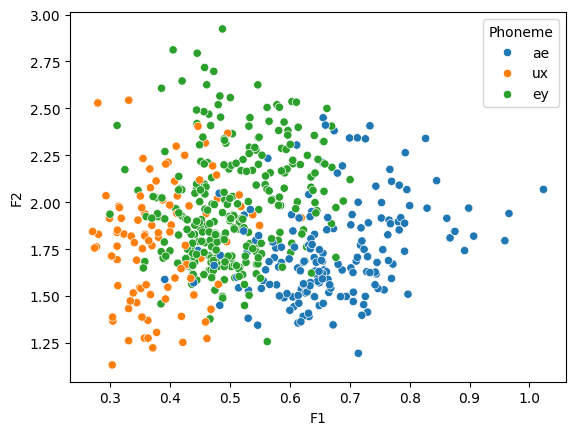

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Extract vowels
train = train[train['Phoneme'].isin(['ae', 'ey', 'ux'])]
test = test[test['Phoneme'].isin(['ae', 'ey', 'ux'])]

# Plotting here
sns.scatterplot(data=train, x='F1', y='F2', hue='Phoneme')
plt.show()

#To take the easiest classes first, ux and ae are the two most separated classes.
#We then see that ey and ae are overlapping a bit more but it is clear that
#ux and ey will be the hardest to classify just by "eying" it.


### Task 2

 Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

In [34]:
features = ['F1','F2']
Xtrain = train[features].to_numpy()
Ytrain = train['Phoneme'].to_numpy()
Xtest = test[features].to_numpy()
Ytest = test['Phoneme'].to_numpy()
classes = np.sort(train['Phoneme'].unique())

# MLE estimates of mu, sigma and priors:

params = {}
priors = {}

for c in classes:
  Xc = Xtrain[Ytrain == c]
  Mu = Xc.mean(axis=0)
  Sigma = np.cov(Xc.T, bias=True)
  params[c] = {
      'mu': Mu,
      'sigma': Sigma,
      'sigma_inv': np.linalg.inv(Sigma),
      'logdet': np.linalg.slogdet(Sigma)[1]
       }
  priors[c] = len(Xc) / len(Xtrain)
  logpriors = {c: np.log(p) for c, p in priors.items()}

def discriminants(X, mu, sigma_inv, logdet, logprior):
  D = X - mu
  q = np.einsum('ij,jk,ik->i', D, sigma_inv, D)
  return -0.5 * (q + logdet) + logprior

def predict(X):
  scores = np.column_stack([discriminants(X, params[c]['mu'], params[c]['sigma_inv'],
                                          params[c]['logdet'], logpriors[c]) for c in classes])

  idx = np.argmax(scores, axis=1)
  return classes[idx], scores, idx

Y_hat = predict(Xtest)[0]
acc = np.mean(Y_hat == Ytest)
print(f"Accuracy: {acc}")





Accuracy: 0.7380073800738007


### Task 3

To visualize the classes models and the classifier created in Task 2, plot the contours for each Gaussian distribution in the model. That is, the class conditional likelihoods $P(x|c)$, by using the following function.

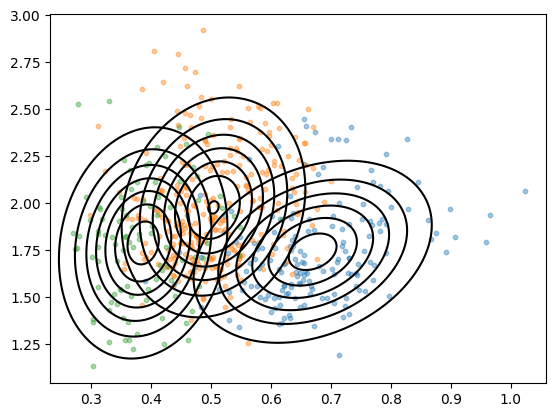

In [35]:
import scipy.stats

def plotGaussian(mean, cov, color, ax):
    """
        Creates a contour plot for a bi-variate normal distribution

        mean: numpy array 2x1 with mean vector
        cov: numpy array 2x2 with covarince matrix
        color: name of color for the plot (see https://matplotlib.org/stable/gallery/color/named_colors.html)
        ax: axis handle where the plot is drawn (can for example be returned by plt.gca() or plt.subplots())
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    mvn = scipy.stats.multivariate_normal(mean, cov)
    lik = mvn.pdf(xy)
    ax.contour(x,y,lik,colors=color)

fig, ax = plt.subplots()
for c in classes:
    pts = train[train.Phoneme==c][['F1','F2']].to_numpy()
    ax.scatter(pts[:,0], pts[:,1], s=10, alpha=0.4)

for c in classes:
    plotGaussian(params[c]['mu'], params[c]['sigma'], 'k', ax)

plt.show()


#### Optional

*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.

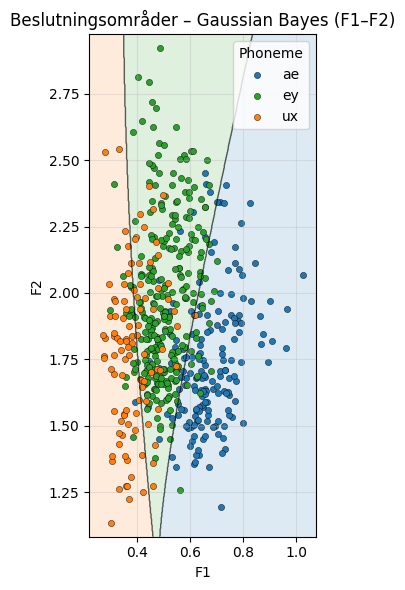

In [36]:
pad = 0.05
x_min, x_max = Xtrain[:,0].min()-pad, Xtrain[:,0].max()+pad
y_min, y_max = Xtrain[:,1].min()-pad, Xtrain[:,1].max()+pad
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]

Z_labels, _ , Z_idx = predict(grid)     # både labels og indeks
Z_labels = Z_labels.reshape(xx.shape)
Z_idx    = Z_idx.reshape(xx.shape)

cmap = {'ae':'#1f77b4','ey':'#2ca02c','ux':'#ff7f0e'}

plt.figure(figsize=(7,6))

# Fylte beslutningsområder (ett lag per klasse)
for i, c in enumerate(classes):
    mask = (Z_idx == i).astype(float)
    plt.contourf(xx, yy, mask, levels=[0.5,1.0], alpha=0.15,
                 colors=[cmap.get(c,'#bbbbbb')])

# Kantlinjer mellom områder (bruker heltallsindekser)
plt.contour(xx, yy, Z_idx,
            levels=np.arange(len(classes)-1)+0.5,
            linewidths=1.0, colors='k', alpha=0.6)

# Treningspunkter oppå
for c in classes:
    pts = Xtrain[Ytrain == c]
    plt.scatter(pts[:,0], pts[:,1], s=20, edgecolor='k', linewidth=0.3,
                c=cmap.get(c,'#bbbbbb'), label=c)

plt.xlabel('F1'); plt.ylabel('F2')
plt.title('Beslutningsområder – Gaussian Bayes (F1–F2)')
plt.legend(title='Phoneme')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Task 4

Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_. That is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

In [37]:


cm = pd.crosstab(Ytest, Y_hat, rownames=['Actual'], colnames=['Predicted'])
print(cm)

Predicted  ae  ey  ux
Actual               
ae         80  24   1
ey         13  97   4
ux          1  28  23


### Task 5

Extend your classifier to include the features "F1"-"F4" and compare the results with those in Task 4.

In [32]:
features = ['F1','F2','F3','F4']

Xtrain = train[features].to_numpy()
Ytrain = train['Phoneme'].to_numpy()
Xtest = test[features].to_numpy()
Ytest = test['Phoneme'].to_numpy()
classes = np.sort(train['Phoneme'].unique())

# MLE estimates of mu, sigma and priors:

params = {}
priors = {}

for c in classes:
  Xc = Xtrain[Ytrain == c]
  Mu = Xc.mean(axis=0)
  Sigma = np.cov(Xc.T, bias=True)
  params[c] = {
      'mu': Mu,
      'sigma': Sigma,
      'sigma_inv': np.linalg.inv(Sigma),
      'logdet': np.linalg.slogdet(Sigma)[1]
       }
  priors[c] = len(Xc) / len(Xtrain)
  logpriors = {c: np.log(p) for c, p in priors.items()}

Y_hat = predict(Xtest)[0]
acc = np.mean(Y_hat == Ytest)
print(f"Accuracy: {acc}")

cm = pd.crosstab(Ytest, Y_hat, rownames=['Actual'], colnames=['Predicted'])
print(cm)

Accuracy: 0.7564575645756457
Predicted  ae  ey  ux
Actual               
ae         82  21   2
ey         13  98   3
ux          2  25  25


### Task 6

Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

In [39]:
features = ['F1','F2','F3','F4','B1','B2','B3','B4']
Xtrain = train[features].to_numpy()
Ytrain = train['Phoneme'].to_numpy()
Xtest = test[features].to_numpy()
Ytest = test['Phoneme'].to_numpy()
classes = np.sort(train['Phoneme'].unique())

# MLE estimates of mu, sigma and priors:

params = {}
priors = {}

for c in classes:
  Xc = Xtrain[Ytrain == c]
  Mu = Xc.mean(axis=0)
  Sigma = np.cov(Xc.T, bias=True)
  params[c] = {
      'mu': Mu,
      'sigma': Sigma,
      'sigma_inv': np.linalg.inv(Sigma),
      'logdet': np.linalg.slogdet(Sigma)[1]
       }
  priors[c] = len(Xc) / len(Xtrain)
  logpriors = {c: np.log(p) for c, p in priors.items()}

Y_hat = predict(Xtest)[0]
acc = np.mean(Y_hat == Ytest)

print(f"Accuracy: {acc}")

cm = pd.crosstab(Ytest, Y_hat, rownames=['Actual'], colnames=['Predicted'])
print(cm)

Accuracy: 0.7121771217712177
Predicted  ae  ey  ux
Actual               
ae         82  23   0
ey         13  90  11
ux          3  28  21


### Task 7

To better understand how important each feature is to the model, we will now perform permutation feature importance (https://scikit-learn.org/stable/modules/permutation_importance.html). The idea is that for each feature we will randomly shuffle the values and the ask the trained model to predict using this shuffled data. We can then observe how the performance degregates as each feature is shuffled.

For the model, take one of the 8 features (four formants and four bandwidths), shuffle and evaluate it 10 times. Repeat this process for each feature. Which feature has the biggest impact on model performance? Does this align with your knowlege of formants?

Below we've provided a sample function to get you started

Baseline accuracy: 0.712
F1: mean_acc=0.466  drop=0.246  (±0.017)
F2: mean_acc=0.655  drop=0.058  (±0.019)
F3: mean_acc=0.692  drop=0.020  (±0.020)
F4: mean_acc=0.711  drop=0.001  (±0.010)
B1: mean_acc=0.699  drop=0.013  (±0.020)
B2: mean_acc=0.696  drop=0.016  (±0.018)
B3: mean_acc=0.725  drop=-0.013  (±0.008)
B4: mean_acc=0.707  drop=0.005  (±0.009)


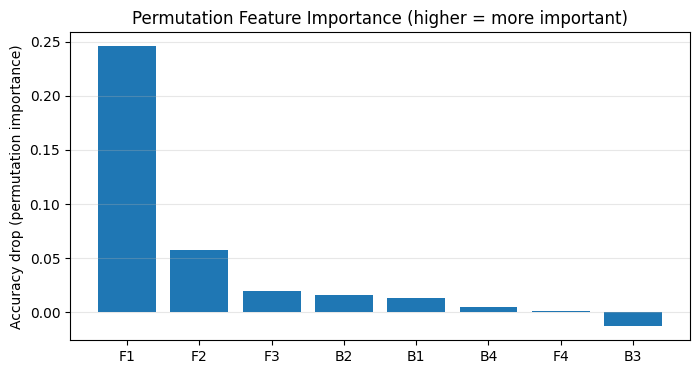

In [48]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Velg features (8D) og lag et "eval DF" fra testsettet ---
features = ['F1','F2','F3','F4','B1','B2','B3','B4']
Xtrain = train[features].to_numpy()
Ytrain = train['Phoneme'].to_numpy()
Xtest = test[features].to_numpy()
Ytest = test['Phoneme'].to_numpy()
classes = np.sort(train['Phoneme'].unique())

# MLE estimates of mu, sigma and priors:

params = {}
priors = {}

for c in classes:
  Xc = Xtrain[Ytrain == c]
  Mu = Xc.mean(axis=0)
  Sigma = np.cov(Xc.T, bias=True)
  params[c] = {
      'mu': Mu,
      'sigma': Sigma,
      'sigma_inv': np.linalg.inv(Sigma),
      'logdet': np.linalg.slogdet(Sigma)[1]
       }
  priors[c] = len(Xc) / len(Xtrain)
  logpriors = {c: np.log(p) for c, p in priors.items()}

# hold bare de kolonnene vi trenger + fasit
eval_df = test.dropna(subset=features+['Phoneme']).copy()
y_true = eval_df['Phoneme'].to_numpy()

# --- 2) Lag en adapter som matcher pseudo-APIet: do_prediction(df) -> y_pred ---
class BayesAdapter:
    def __init__(self, features):
        self.features = features
    def do_prediction(self, df: pd.DataFrame):
        X = df[self.features].to_numpy().astype(float)
        y_pred = predict(X)[0]      # din predict(X) returnerer (labels, scores, idx)
        return y_pred

classifier = BayesAdapter(features=features)

# --- 3) Pseudo-kodens hjelpefunksjon (vi bruker accuracy, men kan lett bytte til error-rate) ---
def calculate_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

# --- 4) Din pseudo-funksjon, tilpasset BayesAdapter + accuracy ---
def do_permutation_eval(classifier, df: pd.DataFrame, feature: str, n_iter: int, rng=None) -> list:
    rng = np.random.default_rng(rng)
    feat_results = []
    for _ in range(n_iter):
        shuffle_df = df.copy(deep=True)
        # stokker verdiene i én kolonne
        shuffled = shuffle_df[feature].to_numpy().copy()
        rng.shuffle(shuffled)
        shuffle_df[feature] = shuffled

        # prediksjon med den stokket kolonnen
        run_pred = classifier.do_prediction(shuffle_df)
        run_acc = calculate_accuracy(shuffle_df['Phoneme'].to_numpy(), run_pred)
        feat_results.append(run_acc)
    return feat_results

# --- 5) Baseline-accuracy (ustokket) ---
baseline_pred = classifier.do_prediction(eval_df)
baseline_acc  = calculate_accuracy(y_true, baseline_pred)
print(f"Baseline accuracy: {baseline_acc:.3f}")

# --- 6) Kjør permutation-importance: 10 stokkinger per feature ---
n_iter = 10
results = {}
drops   = {}

for feat in features:
    acc_list = do_permutation_eval(classifier=classifier, df=eval_df, feature=feat,n_iter=n_iter, rng=42)
    results[feat] = acc_list
    drops[feat] = baseline_acc - np.mean(acc_list)
    print(f"{feat:>2s}: mean_acc={np.mean(acc_list):.3f}  drop={drops[feat]:.3f}  (±{np.std(acc_list, ddof=1):.3f})")

# --- 7) Plot importance (accuracy drop) ---
order = np.argsort([drops[f] for f in features])[::-1]
ordered_feats = [features[i] for i in order]
ordered_drops = [drops[f] for f in ordered_feats]

plt.figure(figsize=(8,4))
plt.bar(ordered_feats, ordered_drops)
plt.ylabel('Accuracy drop (permutation importance)')
plt.title('Permutation Feature Importance (higher = more important)')
plt.grid(axis='y', alpha=0.3)
plt.show()




### Task 8

We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in Task 5.

### Task 9

When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in Task 5 using only diagonal covariance matrices and compare the results.

## Problem 2: SVMs

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

In [ ]:
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

def Plot_SVM_decision_regions(clf: SVC, data: np.array, labels: np.array) -> None:
    '''
    This function is for plotting the decision area of SVM

    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    # we need to use the LabelEncoder here to make contourf work
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    sns.scatterplot(x = data[:,0], y = data[:,1],hue=labels)
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Decision Area of SVM')
    plt.show()

def Plot_Support_Vectors(clf: SVC, data: np.array) -> None:
    '''
    This function is for plotting the support vectors of the SVM model

    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # we need to use the LabelEncoder here to make contourf work
    label_encoder = LabelEncoder()
    Z = label_encoder.fit_transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Support Vectors')
    plt.show()

### Task 10

Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

### Task 11

Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?